# Product Combination Clustering

Use k-mean clusters to separate customers into k groups by the combination of their product options

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
from IPython.display import Audio
sound_file = './beep-01a.wav'

train_data = pd.read_csv('train.csv')

non_purchase_quotes = train_data[train_data.record_type == 0].reset_index(drop=True)
bf_purchase_quotes = non_purchase_quotes.iloc[non_purchase_quotes.groupby('customer_ID').shopping_pt.idxmax()].reset_index(drop=True)

purchase_quotes = train_data[train_data.record_type == 1].reset_index(drop=True)

assert len(purchase_quotes) == len(bf_purchase_quotes)

** If we treat each combination as a vector, we can use PCA to reduce the dimension of the vectors **

In [4]:
from sklearn.decomposition import PCA

options = 'ABCDEFG'
options_list = [option for option in options]
purchase_options = purchase_quotes[options_list]

In [6]:
pca = PCA(n_components=3).fit(purchase_options)
print("Proportion of Variance Explained: {}".format(str(pca.explained_variance_ratio_)))
print("Total Variance Explained by {} components: {}".format(pca.n_components, sum(pca.explained_variance_ratio_)))

Proportion of Variance Explained: [ 0.3349826   0.26210166  0.17337596]
Total Variance Explained by 3 components: 0.7704602181543427


** 3 components can explain approximately 80% of the variance. It is a good number in that we can visualize the dataset in 3D to find out clusters **

In the following code block, I visualize each combination of options as a point in the 3-D space, where the size of each point corresponds to the number of customers that purchased the options

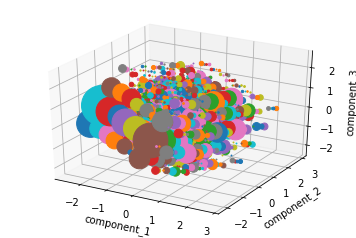

In [7]:
column_names = ['component_' + str(i) for i in range(1, 1 + pca.n_components)]
decomposed_options_counts = pd.DataFrame(pca.transform(purchase_options), columns=column_names).groupby(column_names).size()

from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for idx, item in decomposed_options_counts.iteritems():
    ax.scatter(idx[0], idx[1], idx[2], s=0.8 * item)
ax.set_xlabel('component_1')
ax.set_ylabel('component_2')
ax.set_zlabel('component_3')
plt.show()

** There seem to be 4 obvious clusters, but 5 and 6 can also work. Instead of eyeballing the optimal number of clusters, we use gap statistics to make the choice **

In [10]:
# Adapted from https://github.com/Zelazny7/gap-statistic/blob/master/gap.py
# Estimating the best number of clusters with Gap Statistic
from sklearn.cluster import KMeans, MiniBatchKMeans
from numpy.random import random_sample
from math import sqrt, log

# returns series of random values sampled between min and max values of passed col
def get_rand_data(col):
    rng = col.max() - col.min()
    return pd.Series(random_sample(len(col))*rng + col.min())

def iter_kmeans(df, n_clusters, num_iters=5):
    rng =  range(1, num_iters + 1)
    vals = pd.Series(index=rng)
    for i in rng:
        k = KMeans(n_clusters=n_clusters, n_init=3)
        k.fit(df)
        print("Ref k: %s" % k.get_params()['n_clusters'])
        vals[i] = k.inertia_
    return vals

def gap_statistic(df, max_k=12):
    gaps = pd.DataFrame({'k': [], 'mean': [], 'stderr': []})
    for k in range(1, max_k + 1):
        km_act = KMeans(n_clusters=k, n_init=3)
        km_act.fit(df)

        # get ref dataset
        ref = df.apply(get_rand_data)
        ref_inertiae = iter_kmeans(ref, n_clusters=k)
        #print ref_inertia - km_act.inertia_
        gap = np.log(ref_inertiae) - log(km_act.inertia_)
        gap_mean = gap.mean()
        gap_sem = gap.sem()

        print("Ref: %s   Act: %s  Gap: %s" % ( ref_inertiae.mean(), km_act.inertia_, gap_mean))
        gaps = gaps.append({'k': k, 'mean': gap_mean, 'stderr': gap_sem}, ignore_index=True)

    return gaps.set_index('k')

In [11]:
gap_data = gap_statistic(purchase_options)

Ref k: 1
Ref k: 1
Ref k: 1
Ref k: 1
Ref k: 1
Ref: 298468.504858   Act: 396064.886206  Gap: -0.282913635986
Ref k: 2
Ref k: 2
Ref k: 2
Ref k: 2
Ref k: 2
Ref: 244341.225414   Act: 296437.142574  Gap: -0.19326950463
Ref k: 3
Ref k: 3
Ref k: 3
Ref k: 3
Ref k: 3
Ref: 211266.898669   Act: 253632.295319  Gap: -0.182763449167
Ref k: 4
Ref k: 4
Ref k: 4
Ref k: 4
Ref k: 4
Ref: 184416.746239   Act: 210240.298857  Gap: -0.131053167639
Ref k: 5
Ref k: 5
Ref k: 5
Ref k: 5
Ref k: 5
Ref: 167658.998226   Act: 189818.091108  Gap: -0.124134106729
Ref k: 6
Ref k: 6
Ref k: 6
Ref k: 6
Ref k: 6
Ref: 153510.936499   Act: 173102.845273  Gap: -0.12011408743
Ref k: 7
Ref k: 7
Ref k: 7
Ref k: 7
Ref k: 7
Ref: 143974.997866   Act: 165667.437191  Gap: -0.140342735413
Ref k: 8
Ref k: 8
Ref k: 8
Ref k: 8
Ref k: 8
Ref: 135327.994908   Act: 155712.147764  Gap: -0.140307672457
Ref k: 9
Ref k: 9
Ref k: 9
Ref k: 9
Ref k: 9
Ref: 131351.199869   Act: 150189.582608  Gap: -0.134023731227
Ref k: 10
Ref k: 10
Ref k: 10
Ref k: 10

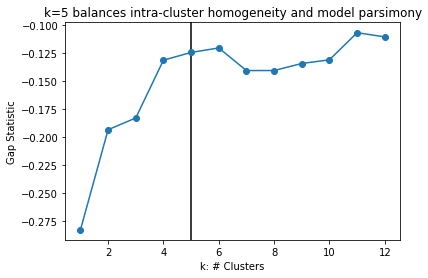

In [12]:
plt.errorbar(gap_data.index, gap_data['mean'], yerr=gap_data['stderr'], fmt='o-')
plt.ylabel('Gap Statistic')
plt.xlabel('k: # Clusters')
plt.axvline(5, color='k')
plt.title('k=5 balances intra-cluster homogeneity and model parsimony')
plt.show()

** Therefore, we choose 5 as our value for k **

## Creating 5 clusters

Cluster Centers are: 
[[ 0.89167629  0.44993177  3.12810958  2.91697281  0.49076309  0.22646164
   1.97470347]
 [ 1.17318436  0.56315278  2.6396648   2.82966966  0.51293418  1.90958222
   1.44018703]
 [ 1.13981381  0.52600017  3.01190975  2.92598339  0.6333557   1.53426151
   3.2892309 ]
 [ 1.20288985  0.52469763  1.22292494  1.87360355  0.50683224  1.85015234
   2.32924014]
 [ 0.1334877   0.27717629  1.30934351  1.97515489  0.06239439  0.04818825
   1.92615308]]
The rounded cluster centers are: 
[[ 1.  0.  3.  3.  0.  0.  2.]
 [ 1.  1.  3.  3.  1.  2.  1.]
 [ 1.  1.  3.  3.  1.  2.  3.]
 [ 1.  1.  1.  2.  1.  2.  2.]
 [ 0.  0.  1.  2.  0.  0.  2.]]
The distribution of the labels are: 


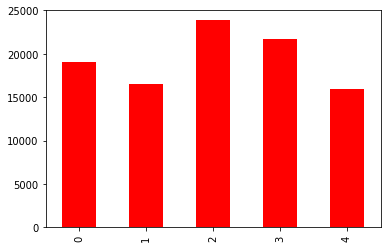

In [15]:
from sklearn.cluster import KMeans
clr = KMeans(n_clusters=5).fit(purchase_options)

print("Cluster Centers are: ")
print(clr.cluster_centers_)
print("The rounded cluster centers are: ")
print (str(np.round(clr.cluster_centers_)))

print ("The distribution of the labels are: ")
labels_count = pd.Series(clr.labels_).groupby(pd.Series(clr.labels_)).size()
labels_count.plot.bar(color='r')
plt.show()

In [17]:
print ("The rounded cluster centers are: ")
print (str(np.round(clr.cluster_centers_)))

color_map = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'yellow',
    4: 'magenta',
    5: 'cyan'
}

# Now visualize the clusters on the 2-D plane
pca_2 = PCA(n_components=2).fit(purchase_options)
column_names = ['component_' + str(i) for i in range(1, 1 + pca_2.n_components)]

decomposed_options_counts = pd.concat([\
                                pd.DataFrame(pca_2.transform(purchase_options), columns=column_names),\
                                pd.Series(clr.labels_, name='Label')\
                            ], axis=1)\
                            .groupby(column_names)['Label']\
                            .agg(['size', 'mean'])
decomposed_options_counts['color'] = map(color_map.get, decomposed_options_counts['mean'])

# Construct variables and draw
x = decomposed_options_counts.index.get_level_values(column_names[0])
y = decomposed_options_counts.index.get_level_values(column_names[1])
s = 0.8 * decomposed_options_counts['size']
colors = decomposed_options_counts['color']
plt.scatter(x, y, s=s, color=colors, alpha=0.4)
c = pca_2.transform(clr.cluster_centers_).transpose()
plt.scatter(c[0], c[1], color='black')
plt.title('Insurance Combinations in 5 Clusters')

plt.show()

The rounded cluster centers are: 
[[ 1.  0.  3.  3.  0.  0.  2.]
 [ 1.  1.  3.  3.  1.  2.  1.]
 [ 1.  1.  3.  3.  1.  2.  3.]
 [ 1.  1.  1.  2.  1.  2.  2.]
 [ 0.  0.  1.  2.  0.  0.  2.]]


ValueError: 'color' kwarg must be an mpl color spec or sequence of color specs.
For a sequence of values to be color-mapped, use the 'c' kwarg instead.

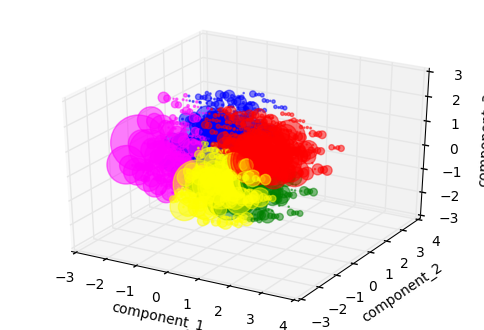

In [5]:
# 3-D Visualization to confirm the clusters

pca_3 = PCA(n_components=3).fit(purchase_options)
column_names = ['component_' + str(i) for i in range(1, 1 + pca_3.n_components)]
decomposed_options_counts = pd.concat([\
                                pd.DataFrame(pca_3.transform(purchase_options), columns=column_names),\
                                pd.Series(clr.labels_, name='Label')\
                            ], axis=1)\
                            .groupby(column_names)['Label']\
                            .agg(['size', 'mean'])
decomposed_options_counts['color'] = map(color_map.get, decomposed_options_counts['mean'])
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = decomposed_options_counts.index.get_level_values(column_names[0])
y = decomposed_options_counts.index.get_level_values(column_names[1])
z = decomposed_options_counts.index.get_level_values(column_names[2])
s = 0.8 * decomposed_options_counts['size']
colors = decomposed_options_counts['color']
ax.scatter(x, y, z, s=s, color=colors, alpha=0.5)

#c = pca_3.transform(clr.cluster_centers_).transpose()
#ax.scatter(c[0], c[1], c[2], s=100, color='black')

ax.set_xlabel('component_1')
ax.set_ylabel('component_2')
ax.set_zlabel('component_3')
plt.show()


## Exploring the properties of the clusters

In [6]:
assert len(purchase_quotes) == len(clr.labels_)
purchase_quotes['label'] = clr.labels_

In [7]:
print np.unique(purchase_quotes.columns)

['A' 'B' 'C' 'C_previous' 'D' 'E' 'F' 'G' 'age_oldest' 'age_youngest'
 'car_age' 'car_value' 'cost' 'customer_ID' 'day' 'duration_previous'
 'group_size' 'homeowner' 'label' 'location' 'married_couple' 'record_type'
 'risk_factor' 'shopping_pt' 'state' 'time']


In [8]:
# Check the proportion of empty values
purchase_quotes.apply(lambda x: len(x[x.isnull()]) / float(len(x)))

customer_ID          0.000000
shopping_pt          0.000000
record_type          0.000000
day                  0.000000
time                 0.000000
state                0.000000
location             0.000000
group_size           0.000000
homeowner            0.000000
car_age              0.000000
car_value            0.000000
risk_factor          0.354050
age_oldest           0.000000
age_youngest         0.000000
married_couple       0.000000
C_previous           0.008618
duration_previous    0.008618
A                    0.000000
B                    0.000000
C                    0.000000
D                    0.000000
E                    0.000000
F                    0.000000
G                    0.000000
cost                 0.000000
label                0.000000
dtype: float64

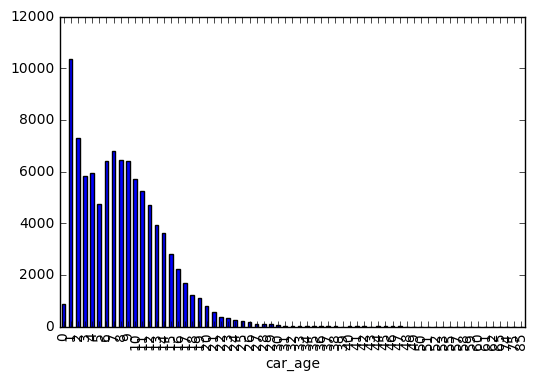

In [9]:
# Examine the difference in car_age
purchase_quotes.groupby('car_age').size().plot.bar()
plt.show()

** Considering the very low proportion of cars more than 30 years of age, we can simply count all of them as 31 **

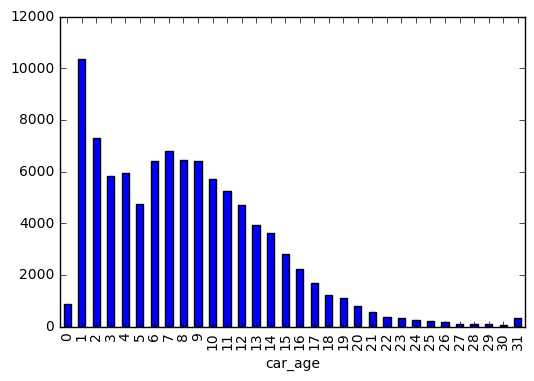

In [13]:
limited_car_age = purchase_quotes['car_age'].apply(lambda x: 31 if x > 30 else x)
limited_car_age.groupby(limited_car_age).size().plot.bar()
purchase_quotes['car_age_limited'] = limited_car_age
plt.show()

In [ ]:
purchase_quotes.groupby(['label', 'car_age_limited']).size().unstack().transpose().plot.bar(stacked=True)

In [ ]:
purchase_quotes['car_age'].plot.kde()
plt.xlim(0, 40)
plt.show()

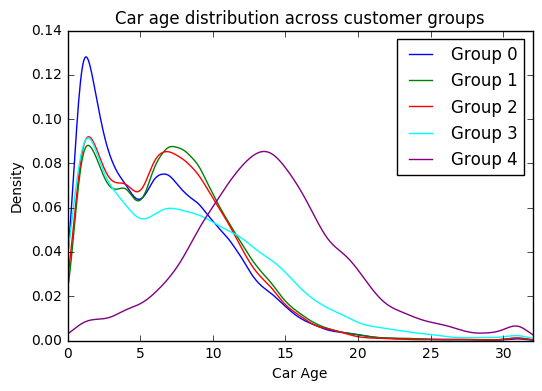

In [38]:
colors = {
    0: 'blue',
    1: 'green',
    2: 'red',
    3: 'cyan',
    4: 'purple'
}
for label in np.unique(purchase_quotes.label):
    purchase_quotes[purchase_quotes.label == label]['car_age_limited'].plot.kde(label='Group {}'.format(label), color=colors[label])
plt.legend()
plt.title('Car age distribution across customer groups')
plt.xlabel('Car Age')
plt.xlim(0, 32)
plt.show()

[  7.48022857e+00   1.14022352e+03   1.90309468e+00   8.58500599e+00
   5.60098634e+03   7.90105311e+00   4.45120401e-01   3.29990275e+04]


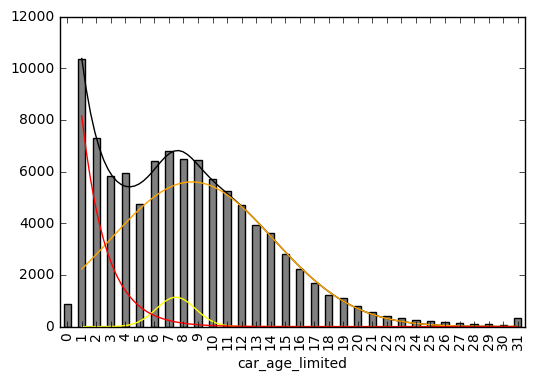

In [71]:
def geometric(x, *params):
    p = params[0]
    n = params[1]
    return n * (1 - p)**x * p

def multi_gaussian(x, *params):
    #print len(params)
    y = np.zeros_like(x)
    begin = 0 if len(params) % 3 == 0 else 2
    for i in range(begin, len(params), 3):
        ctr=params[i]
        amp=params[i+1]
        wid=params[i+2]
        y = y + amp * np.exp(-((x - ctr)/wid)**2)
    return y

def geom_multgaus(x, *params):
    return multi_gaussian(x, *params[:-2]) + geometric(x, *params[-2:])

y = purchase_quotes[purchase_quotes['car_age_limited'] != 0].groupby('car_age_limited').size()
x = y.index.values
guess = [7.5, 5753, 4, 15, 1500, 4, 0.7, 5600]
popt, pcov = curve_fit(geom_multgaus, x, y, p0=guess, bounds=(0, np.inf))
print popt
x_new = np.linspace(min(x), max(x), 100)
y_new = geom_multgaus(x_new, *popt)

y_gauss1 = multi_gaussian(x_new, *popt[0:3])
y_gauss2 = multi_gaussian(x_new, *popt[3:6])
y_geom = geometric(x_new, *popt[6:8])

purchase_quotes.groupby('car_age_limited').size().plot.bar(color='gray')
plt.plot(x_new, y_new, color='k', label='Groups 0, 1, 2 and 3')
plt.plot(x_new, y_gauss1, color='yellow')
plt.plot(x_new, y_gauss2, color='orange')
plt.plot(x_new, y_geom, color='red')
#plt.title('Distribution of Groups 0, 1, 2 and 3 is a mixture of normal and geometric distributions', size=10)
plt.show()


[   13.44364965  1308.15697222     6.54743022]


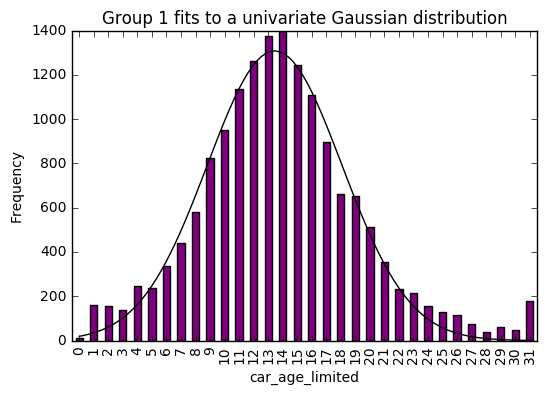

In [73]:
# Fit Group 4 to Gaussian distribution
from scipy.optimize import curve_fit
car_age_group1 = purchase_quotes[purchase_quotes.label == 4].car_age_limited
y = car_age_group1.groupby(car_age_group1).size()
x = y.index.values
def multi_gaussian(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr=params[i]
        amp=params[i+1]
        wid=params[i+2]
        y = y + amp * np.exp(-((x - ctr)/wid)**2)
    return y
# Create a guess for the components of the distribution of group 1
guess = [15, 1500, 4]
popt, pcov = curve_fit(multi_gaussian, x, y, p0=guess)
print popt
x_new = np.linspace(min(x), max(x), 100)
y_new = multi_gaussian(x_new, *popt)
plt.plot(x_new, y_new, color='k')
plt.ylabel('Frequency')
plt.title('Group 1 fits to a univariate Gaussian distribution')
y.plot.bar(color='purple')

plt.show()
popt_unigauss = popt

[  7.46359891e+00   5.75335348e+03   6.51825278e+00   4.88373665e-01
   3.24930477e+04]


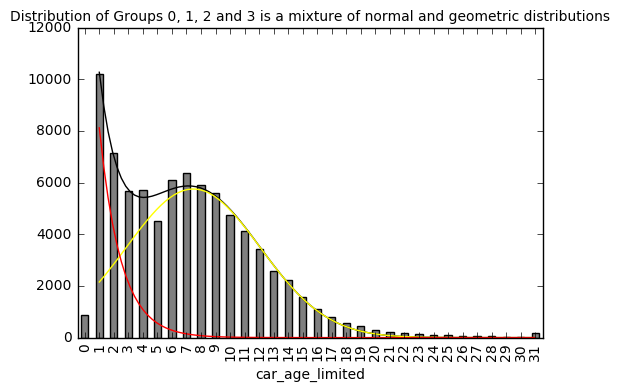

In [74]:
# Fit Groups 0, 1, 2 and 3 to Gaussian distribution
from scipy.optimize import curve_fit
car_age_group24 = purchase_quotes[((purchase_quotes.label != 4))].car_age_limited
y = car_age_group24[(purchase_quotes.car_age_limited != 0)].groupby(car_age_group24).size()
x = y.index.values
def geometric(x, *params):
    p = params[0]
    n = params[1]
    return n * (1 - p)**x * p

def multi_gaussian(x, *params):
    #print len(params)
    y = np.zeros_like(x)
    begin = 0 if len(params) % 3 == 0 else 2
    for i in range(begin, len(params), 3):
        ctr=params[i]
        amp=params[i+1]
        wid=params[i+2]
        y = y + amp * np.exp(-((x - ctr)/wid)**2)
    return y

def geom_multgaus(x, *params):
    return multi_gaussian(x, *params[:-2]) + geometric(x, *params[-2:])
# Create a guess for the components of the distribution of group 1
guess = [7.5, 5753, 4, 0.7, 5600]
popt, pcov = curve_fit(geom_multgaus, x, y, p0=guess, bounds=(0, np.inf))
print popt
x_new = np.linspace(min(x), max(x), 100)
y_new = geom_multgaus(x_new, *popt)
y_gauss = multi_gaussian(x_new, *popt[0:3])
y_geom = geometric(x_new, *popt[3:5])


car_age_group24.groupby(car_age_group24).size().plot.bar(color='gray')
plt.plot(x_new, y_new, color='k', label='Groups 0, 1, 2 and 3')
plt.plot(x_new, y_gauss, color='yellow')
plt.plot(x_new, y_geom, color='red')
plt.title('Distribution of Groups 0, 1, 2 and 3 is a mixture of normal and geometric distributions', size=10)
plt.show()

Gauss 1: mean 13.44, double variance 6.55, n 1308.16
Gauss 2: mean 7.46, double variance 6.52, n 5753.35
Geom : p 0.49, n 32493.05


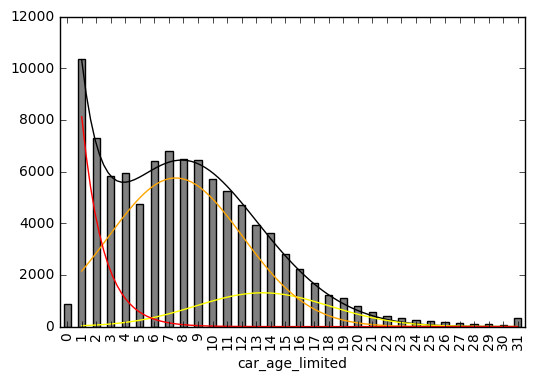

In [82]:
x_new = np.linspace(min(x), max(x), 100)
#y_new = geom_multgaus(x_new, *popt)

y_gauss1 = multi_gaussian(x_new, *popt_unigauss[0:3])
y_gauss2 = multi_gaussian(x_new, *popt[0:3])
y_geom = geometric(x_new, *popt[3:5])

y_new = y_gauss1 + y_gauss2 + y_geom

purchase_quotes.groupby('car_age_limited').size().plot.bar(color='gray')
print "Gauss 1: mean {0:.2f}, double variance {2:.2f}, n {1:.2f}".format(*popt_unigauss[0:3])
print "Gauss 2: mean {0:.2f}, double variance {2:.2f}, n {1:.2f}".format(*popt[0:3])
print "Geom : p {0:.2f}, n {1:.2f}".format(*popt[3:5])
plt.plot(x_new, y_new, color='k', label='Groups 0, 1, 2 and 3')

plt.plot(x_new, y_gauss1, color='yellow')
plt.plot(x_new, y_gauss2, color='orange')
plt.plot(x_new, y_geom, color='red')
plt.show()

Group 0
Geom: p=0.466919937999
Norm: mu=7.32840071008, sigma^2=3.05710118853
Group 1
Geom: p=0.396551854791
Norm: mu=7.91052886003, sigma^2=2.73242589451
Group 2
Geom: p=0.411075837878
Norm: mu=7.64601153828, sigma^2=2.79594782259
Group 3
Geom: p=0.587899950262
Norm: mu=7.39083840963, sigma^2=4.58773245668


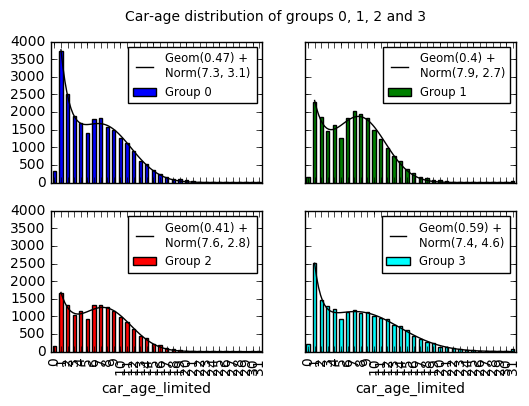

In [60]:
# Fit Groups 0 to mixture distribution
from scipy.optimize import curve_fit
fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)

label = -1
for row in range(0, 2):
    for col in range(0, 2):
        #print row, col
        label += 1
        #print label
        car_age_group = purchase_quotes[((purchase_quotes.label == label))].car_age_limited
        y = car_age_group[(purchase_quotes.car_age_limited != 0)].groupby(car_age_group).size()
        x = y.index.values

        # A guess created from previous trial-and-errors
        guess = [7.5, 5753, 4, 0.7, 5600]
        popt, pcov = curve_fit(geom_multgaus, x, y, p0=guess, bounds=(0, np.inf))
        print "Group {}".format(label)
        print "Geom: p={}".format(popt[-2])
        print "Norm: mu={}, sigma^2={}".format(popt[0], popt[2] / 2)
        x_new = np.linspace(min(x), max(x), 100)
        y_new = geom_multgaus(x_new, *popt)
        car_age_group.groupby(car_age_group).size().plot.bar(ax=axarr[row, col], 
                                                             label='Group {}'.format(label), 
                                                             color=colors[label])
        axarr[row, col].plot(x_new, y_new, color='k', label='Geom({:.2}) + \nNorm({:.2}, {:.2})'.format(popt[-2], popt[0], popt[2] / 2))
        axarr[row, col].legend(fontsize='small')
#fig.legends()
fig.
fig.suptitle('Car-age distribution of groups 0, 1, 2 and 3')
plt.show()

In [ ]:
colors=['blue', 'green', 'red', 'cyan', 'purple']
groupby_label = purchase_quotes.groupby('label')
def ci_95(series):
    return (series.mean() - 2 * series.sem(), series.mean(), series.mean() + 2 * series.sem())
for label, indices in groupby_label.groups.iteritems():
    #print label, ci_95(purchase_quotes.iloc[indices]['car_value_num'])
    #confidence_interval = ci_95(purchase_quotes.iloc[indices]['car_value_num'])
    group = purchase_quotes.iloc[indices]['car_age_limited']
    plt.errorbar(label, group.mean(), yerr=2 * group.sem(), fmt='o', color=colors[label], linewidth=3,\
                 label='Group {}'.format(label))
    #plt.bar(label, group.mean(), 0.35, color=colors[label], yerr=2 * group.sem())
    #print colors[label]
    #plt.axhline(y=label, xmin=confidence_interval[0], xmax=confidence_interval[1], color=colors[label])
plt.legend()
plt.xlim(-1, 5)
plt.show()

In [61]:
print "The rounded cluster centers are: "
for idx, center in enumerate(np.round(clr.cluster_centers_)):
    print idx, center

The rounded cluster centers are: 
0 [ 1.  1.  3.  3.  1.  2.  3.]
1 [ 1.  1.  1.  2.  1.  2.  2.]
2 [ 1.  1.  3.  3.  1.  2.  1.]
3 [ 1.  0.  3.  3.  0.  0.  2.]
4 [ 0.  0.  1.  2.  0.  0.  2.]


In [62]:
car_values = 'abcdefghi'
car_values_nums = '123456789'
car_values_dict = {}
for idx, value in enumerate(car_values):
    car_values_dict[value] = int(car_values_nums[idx])
purchase_quotes['car_value_num'] = purchase_quotes['car_value'].map(car_values_dict)

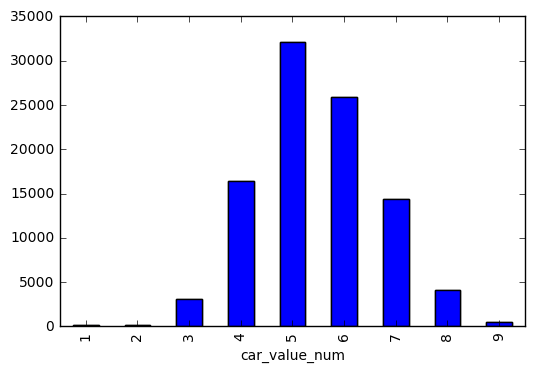

In [64]:
purchase_quotes['car_value_num'].groupby(purchase_quotes['car_value_num']).size().plot.bar()
plt.show()

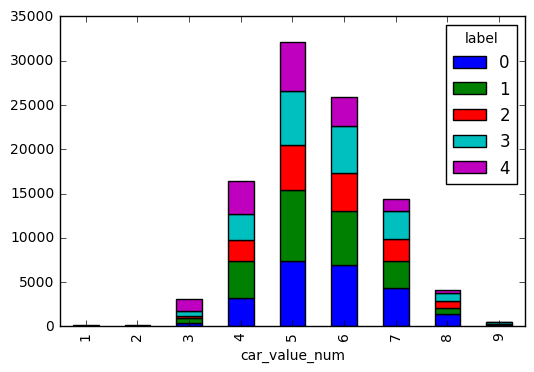

In [83]:
car_value_num_label = purchase_quotes.groupby(['car_value_num', 'label']).size().unstack()
#(car_value_num_label / car_value_num_label.sum(axis='index')).plot(stacked=True)
car_value_num_label.plot.bar(stacked=True)
plt.show()

In [133]:
normal(1, purchase_quotes.car_value_num.sem())

0.9949318096551288

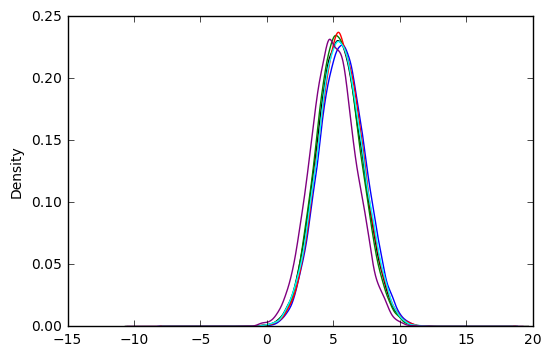

In [135]:
# Generate random samples of car value, assuming that within each car value block the numbers are normally distributed with 
# with the population standard deviation
from numpy.random import normal
stdev = purchase_quotes.car_value_num.std()
car_value_num_random = purchase_quotes.car_value_num.apply(lambda x: normal(x, stdev))
car_value_num_random.plot.kde(color='k')
for label in range(0, 5):
    car_value_num_random[purchase_quotes.label == label].plot.kde(color=colors[label])
plt.show()

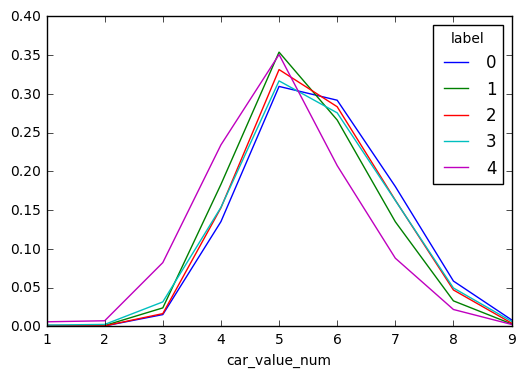

In [66]:
(car_value_num_label / car_value_num_label.sum(axis='index')).plot(stacked=False)
plt.show()

In [ ]:
# Interpolation 
#car_value_num_label = (car_value_num_label / car_value_num_label.sum(axis='index'))

from scipy.interpolate import spline
x_new = np.linspace(min(car_value_num_label.index), max(car_value_num_label.index), 100)
for label in np.unique(purchase_quotes.label):
    #print car_value_num_label[label]
    dist_smooth = spline(car_value_num_label.index.values, car_value_num_label[label].values, x_new)
    plt.plot(x_new, dist_smooth, label='Group {}'.format(label))
plt.legend()
plt.show()
#print x_new

In [ ]:
colors=['blue', 'green', 'red', 'cyan', 'purple']
groupby_label = purchase_quotes.groupby('label')
def ci_95(series):
    return (series.mean() - 2 * series.sem(), series.mean(), series.mean() + 2 * series.sem())
for label, indices in groupby_label.groups.iteritems():
    #print label, ci_95(purchase_quotes.iloc[indices]['car_value_num'])
    #confidence_interval = ci_95(purchase_quotes.iloc[indices]['car_value_num'])
    group = purchase_quotes.iloc[indices]['car_value_num']
    plt.errorbar(label, group.mean(), yerr=2 * group.sem(), fmt='o', color=colors[label], linewidth=3)
    #plt.bar(label, group.mean(), 0.35, color=colors[label], yerr=2 * group.sem())
    #print colors[label]
    #plt.axhline(y=label, xmin=confidence_interval[0], xmax=confidence_interval[1], color=colors[label])
plt.xlim(-1, 5)
plt.show()

** Group 1 has a distribution that seems to center on the left side, whereas Group 3 is centered to the right, but the other ones are close to it, too **

In [ ]:
homeowner_label = purchase_quotes.groupby(['homeowner', 'label']).size().unstack().transpose()
(homeowner_label[1] / homeowner_label.sum(axis='columns')).plot.bar(color='bgrcy')
plt.ylabel('% Homeowners')
#plt.legend()
plt.show()

** Group 1 has the lowest proportion of married couples, and Group 3 has the highest **

In [ ]:
homeowner_label = purchase_quotes.groupby(['married_couple', 'label']).size().unstack().transpose()
(homeowner_label[1] / homeowner_label.sum(axis='columns')).plot.bar(color='bgrcy')
plt.ylabel('% Married Couples')
#plt.legend()
plt.show()

In [ ]:
for label in np.unique(purchase_quotes.label):
    purchase_quotes[purchase_quotes.label == label]['group_size'].plot.kde(label=str(label))
plt.legend()
plt.xlabel('Group Size')
plt.xlim(0, 5)
plt.show()

In [ ]:
purchase_quotes['age_difference'] = purchase_quotes['age_oldest'] - purchase_quotes['age_youngest']
purchase_quotes['single'] = ((purchase_quotes['age_difference'] == 0) & 
                             (purchase_quotes['group_size'] == 1) &
                             (purchase_quotes['married_couple'] == 0))\
                            .map(lambda x: 1 if x else 0)

In [ ]:
print len(purchase_quotes[(purchase_quotes['married_couple'] == 1)]),\
    len(purchase_quotes[(purchase_quotes['married_couple'] == 1) & (purchase_quotes['group_size'] == 3)])

In [ ]:
purchase_quotes['family'] = ((purchase_quotes['group_size'] > 2) &
                             (purchase_quotes['married_couple'] == 1))\
                            .map(lambda x: 1 if x else 0)

In [ ]:
(purchase_quotes[purchase_quotes['family'] == 1].groupby('label').size() / \
purchase_quotes.groupby('label').size().apply(float)).plot.bar()
plt.show()

In [ ]:
homeowner_label = purchase_quotes.groupby(['single', 'label']).size().unstack().transpose()
(homeowner_label[1] / homeowner_label.sum(axis='columns')).plot.bar(color='bgrcy')
plt.ylabel('% Single')
#plt.legend()
plt.show()